# NIH Chest X-ray Multi label Binary classification using Tensorflow Densenet121 (Transfer learning)


In [1]:
# Go to project root folder
import os
os.chdir("../")
%pwd

'/workspaces/chest-x-ray-diagnosis'

## Imports

In [2]:
# Set environment variables
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

import tensorflow as tf
tf.get_logger().setLevel('ERROR')
tf.random.set_seed(42)

2025-03-05 07:21:45.325815: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741159305.369737   10205 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741159305.382864   10205 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
found_gpu = tf.config.list_physical_devices('GPU')
if not found_gpu:
    raise Exception("No GPU found")
found_gpu, tf.__version__

([PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')], '2.18.0')

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import opendatasets as od

from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K


In [5]:
%matplotlib inline

# auto reload libs
%load_ext autoreload
%autoreload 2

## Download the dataset


In [6]:
dataset_url = 'https://www.kaggle.com/datasets/nih-chest-xrays/sample'

# Look into the data directory
datasets = 'datasets/sample'
dataset_path = Path(datasets)
IMAGE_DIR = dataset_path /'sample/images'
CSV_PATH = dataset_path /'sample/sample_labels.csv'
dataset_path.mkdir(parents=True, exist_ok=True)
if not dataset_path.is_dir():
    od.download(dataset_url)

## Paths Setup

In [7]:
from hydra import initialize, compose

# https://gist.github.com/bdsaglam/586704a98336a0cf0a65a6e7c247d248

with initialize(version_base=None, config_path="../conf"):
    cfg = compose(config_name="config")
    print(cfg.DATASET_DIRS.TRAIN_IMAGES_DIR)

datasets/sample/sample/images


## Constants

In [8]:
IMAGE_SIZE = cfg.TRAIN.IMG_SIZE
BATCH_SIZE = cfg.TRAIN.BATCH_SIZE
NUM_EPOCHS = cfg.TRAIN.NUM_EPOCHS
LEARNING_RATE = cfg.TRAIN.LEARNING_RATE

## Load Datasets

In [9]:
from utils.chest_x_ray_preprocessor import ChestXRayPreprocessor

preprocessor = ChestXRayPreprocessor(cfg)
train_ds, valid_ds, test_ds, pos_weights, neg_weights = preprocessor.get_preprocessed_datasets()

I0000 00:00:1741159311.998186   10205 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7354 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:0a:00.0, compute capability: 8.6


In [10]:
for batch in train_ds.take(1):
    images, labels = batch
    print(images.shape, labels.shape)
    print(images[0], labels[0])

(12, 320, 320, 1) (12, 5)
tf.Tensor(
[[[-1.6982776 ]
  [-1.6986825 ]
  [-1.6985135 ]
  ...
  [-0.08215372]
  [-0.06237445]
  [-0.1097601 ]]

 [[-1.6252598 ]
  [-1.6111174 ]
  [-1.6170199 ]
  ...
  [ 1.1871407 ]
  [ 1.1518518 ]
  [ 1.236394  ]]

 [[-1.6839528 ]
  [-1.6815038 ]
  [-1.6825259 ]
  ...
  [ 0.16686012]
  [ 0.17583607]
  [ 0.15433216]]

 ...

 [[-0.5963322 ]
  [-0.75470006]
  [-0.6886023 ]
  ...
  [-1.3898957 ]
  [-1.4317837 ]
  [-1.3314317 ]]

 [[-0.6255653 ]
  [-0.7668524 ]
  [-0.7078838 ]
  ...
  [-1.3709707 ]
  [-1.4153482 ]
  [-1.309032  ]]

 [[-0.5891948 ]
  [-0.751733  ]
  [-0.68389475]
  ...
  [-1.3945163 ]
  [-1.4357966 ]
  [-1.3369008 ]]], shape=(320, 320, 1), dtype=float32) tf.Tensor([0. 0. 1. 0. 0.], shape=(5,), dtype=float32)


In [11]:
# drop_colums = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
#        'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding',
#        'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
# 'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',

# labels =['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
#        'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass',
#        'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
labels = ['Atelectasis','Effusion','Infiltration', 'Mass','Nodule']

#### Compute Class Frequencies

In [12]:
_preprocessor = ChestXRayPreprocessor(cfg)
train_df, _, _ = _preprocessor._load_dataframes()
train_images_df, train_cat_labels_df  = _preprocessor.train_df_clean_up(train_df)
train_cat_labels_df = train_cat_labels_df[labels]

In [13]:
N = train_cat_labels_df.shape[0]
positive_frequencies = (train_cat_labels_df==1).sum()/N
negative_frequencies = (train_cat_labels_df==0).sum()/N
positive_frequencies, negative_frequencies

(Atelectasis     0.090617
 Effusion        0.114877
 Infiltration    0.172494
 Mass            0.050660
 Nodule          0.055833
 dtype: float64,
 Atelectasis     0.909383
 Effusion        0.885123
 Infiltration    0.827506
 Mass            0.949340
 Nodule          0.944167
 dtype: float64)

In [14]:
data_df = pd.DataFrame(list(positive_frequencies.items()), columns=['class', 'positives'])
data_df['negatives'] = negative_frequencies.values
data_df

,class,positives,negatives
0,Atelectasis,0.090617,0.909383
1,Effusion,0.114877,0.885123
2,Infiltration,0.172494,0.827506
3,Mass,0.050660,0.949340
4,Nodule,0.055833,0.944167


<Axes: xlabel='class'>

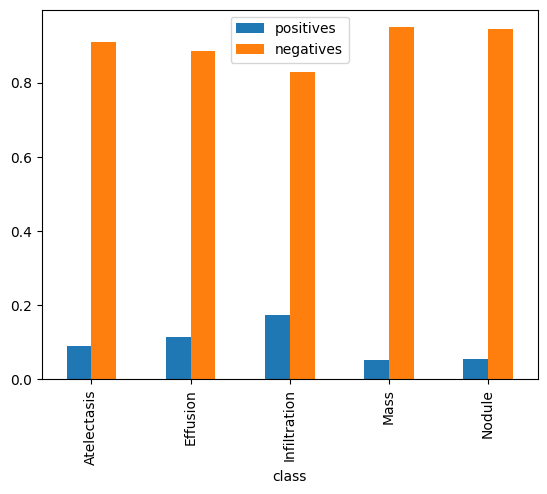

In [15]:
data_df.plot.bar(x='class')

As we see in the above plot, the contributions of positive cases is significantly lower than that of the negative ones. However, we want the contributions to be equal. One way of doing this is by multiplying each example from each class by a class-specific weight factor, $w_{pos}$ and $w_{neg}$, so that the overall contribution of each class is the same. 

To have this, we want 

$$w_{pos} \times freq_{p} = w_{neg} \times freq_{n},$$

which we can do simply by taking 

$$w_{pos} = freq_{neg}$$
$$w_{neg} = freq_{pos}$$

This way, we will be balancing the contribution of positive and negative labels.

In [16]:
_pos_weights = negative_frequencies.values
_neg_weights = positive_frequencies.values
# positive_frequencies.values

# Try adjusting the weight balance slightly
# pos_weights = np.sqrt(negative_frequencies.values) * 0.8  # Reduce positive weight slightly
# neg_weights = np.sqrt(positive_frequencies.values) * 1.2  # Increase negative weight slightly

In [17]:
pos_contirbution = positive_frequencies * _pos_weights
neg_contribution = negative_frequencies * _neg_weights

pos_contirbution, neg_contribution

(Atelectasis     0.082406
 Effusion        0.101680
 Infiltration    0.142740
 Mass            0.048094
 Nodule          0.052716
 dtype: float64,
 Atelectasis     0.082406
 Effusion        0.101680
 Infiltration    0.142740
 Mass            0.048094
 Nodule          0.052716
 dtype: float64)

In [18]:
weighted_data_df = pd.DataFrame(list(pos_contirbution.items()), columns=['class', 'positives'])
weighted_data_df['negatives'] = neg_contribution.values
weighted_data_df

,class,positives,negatives
0,Atelectasis,0.082406,0.082406
1,Effusion,0.101680,0.101680
2,Infiltration,0.142740,0.142740
3,Mass,0.048094,0.048094
4,Nodule,0.052716,0.052716


<Axes: xlabel='class'>

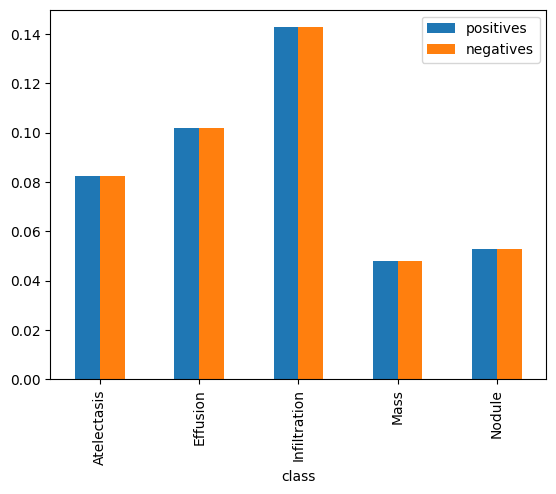

In [19]:
weighted_data_df.plot.bar(x='class')

## Weighted loss calculation to handle class imbalance

As the above figure shows, by applying these weightings the positive and negative labels within each class would have the same aggregate contribution to the loss function. Now let's implement such a loss function. 

After computing the weights, our final weighted loss for each training case will be 

$$\mathcal{L}_{cross-entropy}^{w}(x) = - (w_{p} y \log(f(x)) + w_{n}(1-y) \log( 1 - f(x) ) ).$$

In [20]:
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    """
    Return weighted loss function given negative weights and positive weights.

    Args:
      pos_weights (np.array): array of positive weights for each class, size (num_classes)
      neg_weights (np.array): array of negative weights for each class, size (num_classes)
    
    Returns:
      weighted_loss (function): weighted loss function
    """
    def weighted_loss(y_true, y_pred):
        """
        Return weighted loss value. 

        Args:
            y_true (Tensor): Tensor of true labels, size is (num_examples, num_classes)
            y_pred (Tensor): Tensor of predicted labels, size is (num_examples, num_classes)
        Returns:
            loss (float): overall scalar loss summed across all classes
        """
        # initialize loss to zero
        loss = 0.0

        for i in range(len(pos_weights)):
            y = y_true[:, i]
            f_of_x = y_pred[:, i]

            f_of_x_log = K.log(f_of_x + epsilon)
            f_of_x_1_min_log = K.log((1-f_of_x) + epsilon)

            first_term = pos_weights[i] * y * f_of_x_log
            sec_term = neg_weights[i] * (1-y) * f_of_x_1_min_log
            loss_per_col = - K.mean(first_term + sec_term)
            loss += loss_per_col
        return loss

    return weighted_loss



## Model Development

### Load and Prepare DenseNet121 Model

In [21]:
#'imagenet',

base_model = DenseNet121(
     include_top=False,
     weights='pretrain_weights/densenet.hdf5', #'imagenet', 
     input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)  
)
# base_model.trainable = False


x = base_model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(4096, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
# and a logistic layer
predictions = Dense(len(labels), activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)


In [22]:
METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='AUC'), 
]

In [23]:
tf.keras.backend.clear_session()

LEARNING_RATE = 0.1
EPOCHS = 50
# model = build_model()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), 
               loss=get_weighted_loss(pos_weights, neg_weights),
        metrics=METRICS)     

# model.summary()

## Model training

## Callbacks

In [24]:
CHECK_POINT_DIR = 'exported_models'
checkpoint_prefix = os.path.join(CHECK_POINT_DIR, "ckpt_{epoch}.keras")
LOG_DIR = 'logs'

In [25]:
callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir=LOG_DIR),
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix,
                                        save_best_only=True, # Save only the best model based on val_loss
                                        monitor='val_loss',
                                        mode='min',
                                        verbose=1),  # Display checkpoint saving messages
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
]

In [26]:
history = model.fit(train_ds, 
                    validation_data=valid_ds,
                    epochs = EPOCHS,
                    callbacks=callbacks)

Epoch 1/50


I0000 00:00:1741079326.662789   17142 service.cc:148] XLA service 0x7af98c002e20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1741079326.662845   17142 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
I0000 00:00:1741079331.825752   17142 cuda_dnn.cc:529] Loaded cuDNN version 90701
I0000 00:00:1741079390.749525   17142 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


468/468 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - AUC: 0.4998 - accuracy: 0.0845 - loss: 6.3243 - precision: 0.0852 - recall: 0.2619
Epoch 1: val_loss improved from inf to 6.43619, saving model to exported_models/ckpt_1.keras
468/468 ━━━━━━━━━━━━━━━━━━━━ 215s 251ms/step - AUC: 0.4998 - accuracy: 0.0846 - loss: 6.3254 - precision: 0.0852 - recall: 0.2619 - val_AUC: 0.5465 - val_accuracy: 0.0900 - val_loss: 6.4362 - val_precision: 0.1350 - val_recall: 0.2842 - learning_rate: 0.1000
Epoch 2/50
467/468 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - AUC: 0.5042 - accuracy: 0.0857 - loss: 6.3784 - precision: 0.0901 - recall: 0.2733
Epoch 2: val_loss did not improve from 6.43619
468/468 ━━━━━━━━━━━━━━━━━━━━ 43s 91ms/step - AUC: 0.5042 - accuracy: 0.0857 - loss: 6.3805 - precision: 0.0902 - recall: 0.2732 - val_AUC: 0.5465 - val_accuracy: 0.0900 - val_loss: 6.4362 - val_precision: 0.1350 - val_recall: 0.2842 - learning_rate: 0.1000
Epoch 3/50
467/468 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - AUC: 0.5046 - accuracy:

## Fine-Tune the Model
Right now, our model is sort of smart. We'll change the learning rate so it doesn't jump to conclusions too quickly.

In [27]:
# base_model.trainable = True
# fine_tune_at = 149 

# # Freeze all layers before the fine_tune_at layer
# for layer in base_model.layers[:fine_tune_at]:
#     layer.trainable = False

# # Recompile the model with a lower learning rate
# model.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
#     loss=get_weighted_loss(pos_weights, neg_weights),
#     metrics=METRICS
# )

# # Set the number of epochs for fine-tuning
# fine_tune_epochs = 20
# total_epochs = EPOCHS + fine_tune_epochs  # Total epochs

# # Continue training the model with fine-tuning
# history_fine = model.fit(
#     train_ds,
#     epochs=total_epochs,
#     initial_epoch=history.epoch[-1],  # Start from the last epoch of initial training
#     validation_data=valid_ds,
#     callbacks=callbacks  
# )

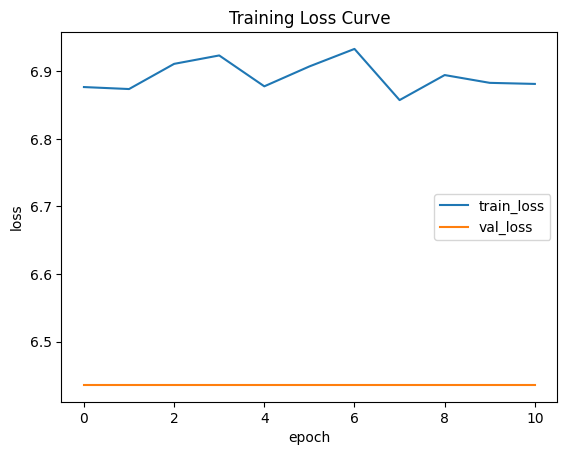

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train_loss', 'val_loss'])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Training Loss Curve")
plt.show()

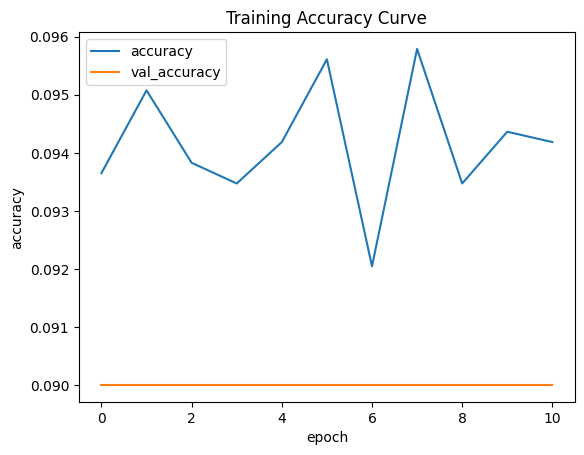

In [29]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.title("Training Accuracy Curve")
plt.show()